In [11]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(threshold=np.inf)
from scipy import constants
from scipy.special import sph_harm, genlaguerre
from scipy.sparse import diags
from math import sqrt, factorial, pi
from scipy.optimize import curve_fit

In [24]:
hbar = 1   # unitless
m_H = 5e5 #ev
R_H = 2.68E-4 #1/ev

m = m_H#.1
R = R_H#3.2E13
U = .01
distance = (R)*70
earth_cutoff = R / distance
e = .303 #unitless
epsilon_0 = 1 #unitless

# look into whether or not I need to negate second deriv - I'm inclined to say no because it's mostly working tbh but make sure it doesn't matter that it's 2, not -2 on diagonals
# I ended up negative it so it's now -2 on diagonals


# Based on the condition given in equation 3, the eigenvalue k^2 << (m*U)^3/2 * R in order for there to be a large asymmetry
k_condition = (m*U)**(3/2) * R
print("k squared condition: ", k_condition)

# kr should be order 1, delta should be order 1, with k = 1E-4
# use this to vary the kr >> 1 whatever it was
# only think about the inequality in terms of k = 1E-4
# if we're doing a FD cutoff, use like 1E-3




#actual values:
# R = 3.2E13 1/ev
# U = 1E-14

k squared condition:  94.75230867899737


In [13]:
# define derivative matrices

def first_deriv(N, r):
    diags0 = np.zeros(N)

    ddr = np.diag(diags0)

    for i in range(0, ddr.shape[0]):
        if i != 0:
            ddr[i,i-1] = -1
        if i != ddr.shape[0]-1:
            ddr[i,i+1] = 1
    
    delta_x = r[1] - r[0]

    return ddr / (2 * delta_x)


# Large numbers at the first few spots because this is how we remove the condition that
# the wavefunction must be zero at the origin
def second_deriv(N, r):
    diags2 = np.full(N, -2.0)

    d2dr = np.diag(diags2)

    for i in range(0, d2dr.shape[0]):
        if i == 0:
            d2dr[i,i] = -1E200
            d2dr[i,i+1] = 1E200
        if i > 0:
            d2dr[i,i-1] = 1.0
        if i != d2dr.shape[0]-1 and i != 0:
            d2dr[i,i+1] = 1.0

    delta_x =  r[1] - r[0]
    return d2dr / (delta_x**2)

# def second_deriv(N, r):
#     diags2 = np.full(N, -2)

#     d2dr = np.diag(diags2)

#     for i in range(0, d2dr.shape[0]):
#         if i != 0:
#             d2dr[i,i-1] = 1
#         if i != d2dr.shape[0]-1:
#             d2dr[i,i+1] = 1

#     delta_x =  r[1] - r[0]
#     return d2dr / (delta_x**2)

def normalize(psi):

    norm = np.sqrt(np.sum(np.abs(psi)**2))  # Compute the norm of the vector
    psi_norm = psi / norm  # Normalize the vector
    return psi_norm


In [14]:
# Potentials and Hamiltonian from equation 25


def potential_nu_25(N, r, l):

    H = np.zeros((N,N))
    for i in range(0, H.shape[0]):
        #try just a step function
        
        # inside the earth:
        
        V_eff_in = (l * (l + 1))/(r[i]**2) + 2 * m * U

        # outside the earth:
        V_eff_out = (l * (l + 1))/(r[i]**2)

        if r[i] < R:
            H[i,i] = V_eff_in
        else:
            H[i,i] = V_eff_out

    return H

def potential_antinu_25(N, r, l):

    H = np.zeros((N,N))
    for i in range(0, H.shape[0]):
        #try just a step function
        
        # inside the earth:
        V_eff_in_neg = (l * (l + 1))/(r[i]**2) - 2 * m * U

        # outside the earth:
        V_eff_out_neg = (l * (l + 1))/(r[i]**2)
        #print("In, Out neg: ", V_eff_in_neg, V_eff_out_neg)

        if r[i] < R:
            H[i,i] = V_eff_in_neg
        else:
            H[i,i] = V_eff_out_neg
    return H

def potential_H_atom(N, r, l):
    H = np.zeros((N,N))
    for i in range(0, H.shape[0]):
        H[i,i] = -e**2 / (4 * constants.pi * r[i] * epsilon_0) + (hbar**2 * l * (l + 1)) / (2 * m * r[i]**2)
    return H


# create the equation to be solved: Hψ = (k^2)ψ
def Hamiltonian_nu_25(N, r, l):
    H = - second_deriv(N, r) + potential_nu_25(N,r, l)
    return H

def Hamiltonian_antinu_25(N, r, l):
    H = - second_deriv(N, r) + potential_antinu_25(N,r, l)
    return H

def Hamiltonian_H_atom(N, r, l):
    H = (hbar**2 / (2 * m)) * second_deriv(N, r) + potential_H_atom(N,r, l)
    return H


V_nu:  [2.00000000e+10 1.41823776e+10 1.05779354e+10 8.19141015e+09
 6.53005246e+09 5.32726795e+09 4.42859677e+09 3.73953163e+09
 3.19961600e+09 2.76871661e+09 2.41934413e+09 2.13215759e+09
 1.89322895e+09 1.69232195e+09 1.52177720e+09 1.37577119e+09
 1.24981250e+09 1.14039219e+09 1.04473675e+09 9.60630597e+08
 8.86286633e+08 8.20250506e+08 7.61328944e+08 7.08535470e+08
 6.61048838e+08 6.18180904e+08 5.79351553e+08 5.44068969e+08
 5.11913986e+08 4.82527580e+08 4.55600800e+08 4.30866622e+08
 4.08093296e+08 3.87078903e+08 3.67646860e+08 3.49642199e+08
 3.32928470e+08 3.17385147e+08 3.02905447e+08 2.89394495e+08
 2.76767761e+08 2.64949739e+08 2.53872813e+08 2.43476291e+08
 2.33705567e+08 2.24511405e+08 2.15849318e+08 2.07679029e+08
 1.99964001e+08 1.92671028e+08 1.85769877e+08 1.79232974e+08
 1.73035130e+08 1.67153295e+08 1.61566345e+08 1.56254893e+08
 1.51201119e+08 1.46388620e+08 1.41802279e+08 1.37428144e+08
 1.33253322e+08 1.29265886e+08 1.25454787e+08 1.21809779e+08
 1.18321348e+08 1

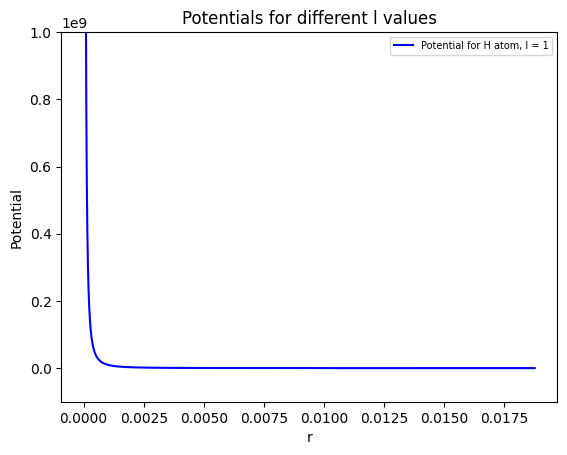

In [17]:
def plot_potentials(N, l_values):
    
    r_values = np.linspace(1E-5, distance, N)
    
    # Create a list of colors for the different l values
    colors = ['blue', 'green', 'red', 'purple', 'orange']

    for i, l in enumerate(l_values):
        # Calculate the potential matrices
        potential_nu = potential_nu_25(N, r_values, l)
        potential_antinu = potential_antinu_25(N, r_values, l)
        potential_H = potential_H_atom(N, r_values, l)

        # Extract the diagonal values
        V_nu = np.diag(potential_nu)
        V_antinu = np.diag(potential_antinu)
        print("V_nu: ", V_nu)
        V_H = np.diag(potential_H)
        # print("V_H: ", V_H)

        # Plot the potentials
        # plt.plot(r_values, V_nu, color=colors[i], label=f'Potential for neutrinos, l = {l}')
        # plt.plot(r_values, V_antinu, color=colors[i], linestyle='dashed', label=f'Potential for antineutrinos, l = {l}')
        plt.plot(r_values, V_H, color=colors[i], label=f'Potential for H atom, l = {l}')

    plt.xlabel('r')
    plt.ylabel('Potential')
    # plt.yscale('log')
    #plt.xscale('log')
    plt.ylim(-1E8, 1E9)
    plt.title('Potentials for different l values')
    #plt.hlines(3.9E-17, xmin=0, xmax=distance, linestyle='dashed', color='black')
    #plt.hlines(-4.9e-16, xmin=0, xmax=distance, linestyle='dashed', color='black')
    
    # Adjust legend size and position
    plt.legend(fontsize=7, loc='upper right')

    plt.savefig('1D_plots/potentials.png')
    plt.show()

# Call the function with a list of l values
plot_potentials(10000, [1])

In [18]:
def analytical_solution(n, l, r):
    # Constants
    Z = 1  # For hydrogen
    a0 = 2.68E-4  # Bohr radius

    # Normalization factor
    N = sqrt((2*Z/a0)**3 * factorial(n-l-1)/(2*n*(factorial(n+l))**3))

    # Associated Laguerre polynomial
    L = genlaguerre(n-l-1, 2*l+1)

    # Radial part of the wave function
    R = N * np.exp(-Z*r/(n*a0)) * (2*Z*r/(n*a0))**l * L(2*Z*r/(n*a0))

    return R

In [19]:
def H_atom_graphing(N, nl_pairs):
    fig, axs = plt.subplots(2, 1, figsize=(8, 12))  # Create a figure with two subplots

    all_eigenvalues = []  # List to store all eigenvalues
    #I've removed the first psi from all of them just to see if that cleans it up - it seems to have a little bit but idk how allowed that is lol
    for n, l in nl_pairs:
        r_values = np.linspace(1E-10, distance, N)
        E, u = np.linalg.eigh(Hamiltonian_H_atom(N, r_values, l))
        u = u.T / r_values
        
        print("Energy n-l-1:", E[n-l-1])

        #E = E[1:]
        all_eigenvalues.append(E)  # Append the eigenvalues to the list

        psi = normalize(u[n-l-1])
        print("Energy: ", E)
        print("Wavefunction squared: ", np.sum(psi**2))

        # Plot the numerical solution
        axs[0].plot(r_values, (psi**2), label=f'Numerical solution for n = {n}, l = {l}')

        # Compute and plot the analytical solution
        psi_analytical = normalize(analytical_solution(n, l, r_values))
        print("wavefunction squared analytical: ", np.sum(psi_analytical**2))
        axs[0].plot(r_values, (psi_analytical**2), label=f'Analytical solution for n = {n}, l = {l}')
    
    axs[0].legend()
    axs[0].set_yscale('linear')

    # Plot all eigenvalues in the second subplot
    axs[1].plot(np.concatenate(all_eigenvalues), marker='o')
    axs[1].set_title('Eigenvalues')
    axs[1].set_xlabel('Index')
    axs[1].set_ylabel('Eigenvalue')

    plt.tight_layout()
    plt.show()

Energy n-l-1: -0.8340276086822616
Energy:  [-1.48270312e+000 -8.34027609e-001 -5.32767944e-001 -3.37756129e-001
 -1.05866565e-001  1.96860170e-001  5.65908327e-001  9.97867728e-001
  1.49081205e+000  2.04354755e+000  2.65527545e+000  3.32542928e+000
  4.05358874e+000  4.83943042e+000  5.68269793e+000  6.58318283e+000
  7.54071196e+000  8.55513871e+000  9.62633687e+000  1.07541961e+001
  1.19386188e+001  1.31795171e+001  1.44768115e+001  1.58304290e+001
  1.72403020e+001  1.87063674e+001  2.02285655e+001  2.18068398e+001
  2.34411364e+001  2.51314030e+001  2.68775895e+001  2.86796467e+001
  3.05375269e+001  3.24511828e+001  3.44205683e+001  3.64456375e+001
  3.85263448e+001  4.06626451e+001  4.28544933e+001  4.51018443e+001
  4.74046531e+001  4.97628744e+001  5.21764628e+001  5.46453728e+001
  5.71695583e+001  5.97489732e+001  6.23835706e+001  6.50733037e+001
  6.78181248e+001  7.06179859e+001  7.34728386e+001  7.63826337e+001
  7.93473217e+001  8.23668523e+001  8.54411749e+001  8.85702

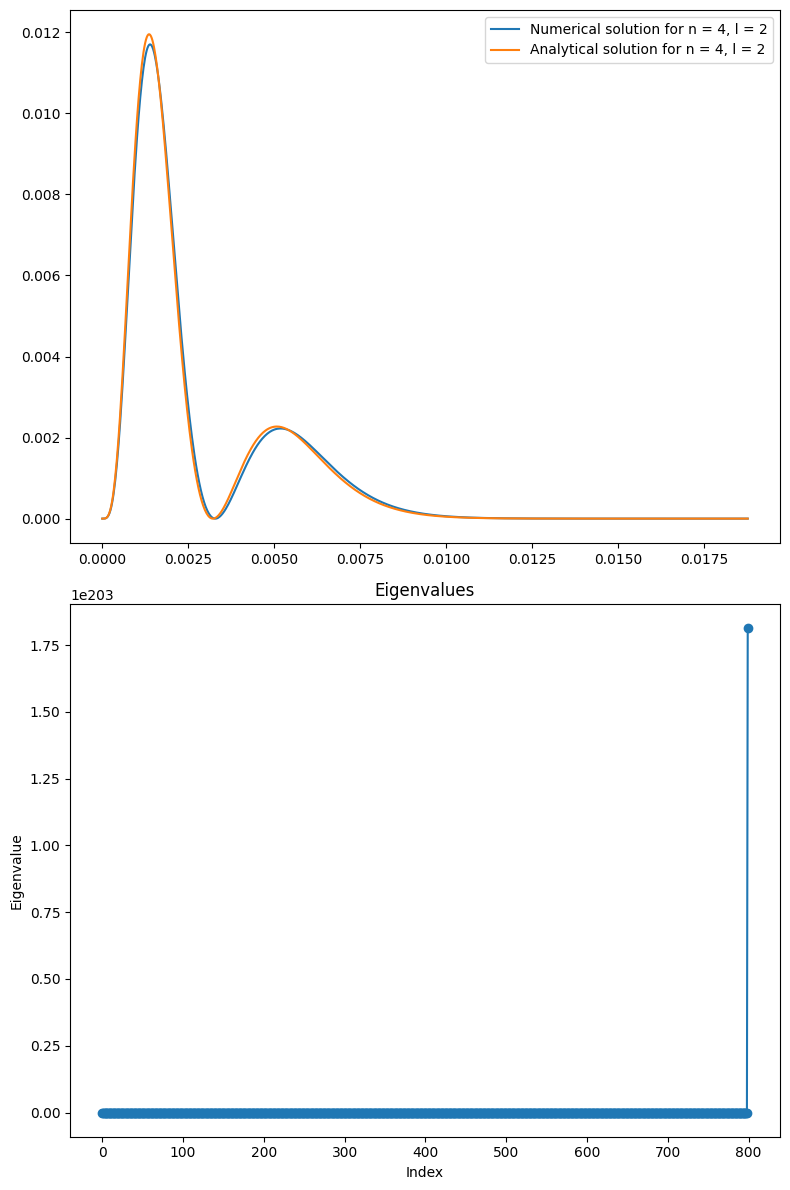

In [26]:
H_atom_graphing(800, [(4,2)])

In [611]:
def H_atom_vary_R(N_values, nl_pairs):
    all_energies = []  # List to store all eigenvalues for each N
    all_r_values_list = []  # List to store all r values for each N
    for N in N_values:
        energies = []  # List to store all eigenvalues for this N
        r_values_list = []  # List to store all r values for this N
        for n, l in nl_pairs:
            for r in range(1000, 1001000, 100000):
                r_values = np.linspace(1E-10, R*r, N)
                E, u = np.linalg.eigh(Hamiltonian_H_atom(N, r_values, l))
                u = u.T / r_values
            
                print("Energy n-l:", E[n-l])
                energies.append(E[n-l])
                r_values_list.append(r)
        all_energies.append(energies)
        all_r_values_list.append(r_values_list)

    return all_r_values_list, all_energies

In [616]:
N_values = [7000, 8000, 9000, 10000, 11000]
all_r_values_list, all_energies = H_atom_vary_R(N_values, [(1,0)])

Energy n-l: -2741.392712724819
Energy n-l: -2.027545683879816
Energy n-l: -0.9836130255688786
Energy n-l: -0.6491188601814566
Energy n-l: -0.48436702120465
Energy n-l: -0.38631000156599543
Energy n-l: -0.32126848882710723
Energy n-l: -0.2749714878019439
Energy n-l: -0.24033677885841287
Energy n-l: -0.21345078900116649
Energy n-l: -3576.6717312434366
Energy n-l: -2.340722669252168
Energy n-l: -1.129872399111935
Energy n-l: -0.7443843770331062
Energy n-l: -0.5549838344815515
Energy n-l: -0.44240599793960167
Energy n-l: -0.36779506528015254
Energy n-l: -0.31471696711093505
Energy n-l: -0.2750259906514111
Energy n-l: -0.2442248243133449
Energy n-l: -4523.329441911187
Energy n-l: -2.6600179516806293
Energy n-l: -1.277594180975603
Energy n-l: -0.8402895986384592
Energy n-l: -0.6259575684712353
Energy n-l: -0.4987292991843179
Energy n-l: -0.41447897017854246
Energy n-l: -0.3545777600759673
Energy n-l: -0.3098033315521373
Energy n-l: -0.2750683953492059
Energy n-l: -5581.367607103793
Energy n-

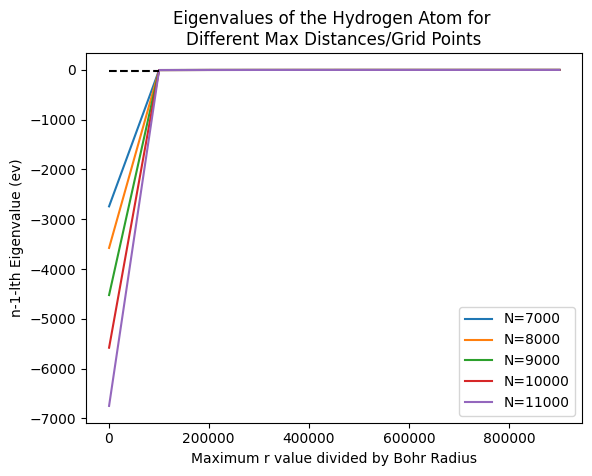

In [617]:
# Loop over each N
for i in range(len(all_r_values_list)):
    # Plot the results for this N
    plt.plot(all_r_values_list[i], all_energies[i], label='N={}'.format(N_values[i]))

plt.xlabel('Maximum r value divided by Bohr Radius')
plt.ylabel('n-1-lth Eigenvalue (ev)')
plt.title('Eigenvalues of the Hydrogen Atom for \nDifferent Max Distances/Grid Points') 
plt.hlines(-13.6, xmin=0, xmax=100000, linestyle='dashed', color='black')

# Show the legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
# function to graph the nth harmonic
#try solving equation 25 instead


def harmonic(n, N, l):
    
    global r_values, psi_antinu, psi_nu
    
    r_values = np.linspace(0.00001, distance, N)
    E_pos, psi_nu = np.linalg.eigh(Hamiltonian_nu_25(N, r_values, l))
    E_neg, psi_antinu = np.linalg.eigh(Hamiltonian_antinu_25(N, r_values, l))
    psi_nu = psi_nu.T
    psi_antinu = psi_antinu.T
    print(f'neutrino energy {n}:', E_pos[n-1])
    print(f'antineutrino energy {n}:', E_neg[n-1])

    # Create two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the first two graphs on the first subplot
    # divide by r_values bc equation 25 defines phi = r*psi
    #Calculate the integral of the absolute square of psi/r over all space
    norm_nu = np.trapz(np.abs(psi_nu[n-1] / r_values)**2, r_values)
    norm_antinu = np.trapz(np.abs(psi_antinu[n-1] / r_values)**2, r_values)

    # Divide psi by the square root of this integral to renormalize
    psi_nu_normalized = psi_nu[n-1] / np.sqrt(norm_nu)
    psi_antinu_normalized = psi_antinu[n-1] / np.sqrt(norm_antinu)


    # Now plot the normalized functions
    ax1.plot(r_values, np.abs(psi_nu_normalized / r_values)**2, color = 'blue', label=f'Potential for neutrinos: n = {n}')
    ax1.plot(r_values, np.abs(psi_antinu_normalized / r_values)**2, color = 'green', label=f'Potential antineutrinos: n = {n}')

    # ax1.plot(r_values, np.abs(psi_pos[n-1] / r_values)**2, color = 'blue', label=f'Potential unchanged: n = {n}')
    # ax1.plot(r_values, np.abs(psi_neg[n-1] / r_values)**2, color = 'green', label=f'Potential negative: n = {n}')


    # Plot the asymmetry on the second subplot
    asym = []
    for i in range(0, len(r_values)):
        if np.abs(psi_nu_normalized[i] / r_values[i])**2 == np.abs(psi_antinu_normalized[i] / r_values[i])**2 and np.abs(psi_nu_normalized[i] / r_values[i])**2 == 0:
            asym.append(0)
        else:
            asym.append((np.abs(psi_nu_normalized[i] / r_values[i])**2 - np.abs(psi_antinu_normalized[i] / r_values[i])**2)/(np.abs(psi_nu_normalized[i] / r_values[i])**2 + np.abs(psi_antinu_normalized[i] / r_values[i])**2))
    ax2.plot(r_values, asym, color='red', label='Asymmetry') # graphing numerically
    
    # graph the potential on the same plot
    #ax1.vlines(3E13, ymin = 0, ymax=.001)
    #ax2.vlines(3E13, ymin = 0, ymax=1)

    # Set labels and title for the first subplot
    ax1.set_xlabel('r')
    ax1.set_ylabel(r'$\mid\psi\mid^2$')
    ax1.set_yscale('linear')
    ax1.set_xscale('linear')
    ax1.set_title(f'Harmonic {n} Probability Distribution')

    # Set labels and title for the second subplot
    ax2.set_xlabel('r')
    ax2.set_ylabel(r'$\mid\psi\mid^2$')
    ax2.set_yscale('linear')
    ax2.set_xscale('linear')
    ax2.set_title(f'Asymmetry: {N} points, l = {l}')

    # Display legend
    ax1.legend()
    ax2.legend()

    # Save the figure
    plt.savefig('1D_plots/step_function.png')

    # Show the plot
    plt.show()


# harmonic(1, 1000, l=800000)
# harmonic(1, 2000, l=800000)
# harmonic(1, 3000, l=800000)

In [606]:
def harmonic_many_N(n, N_values, l):
    
    global r_values, psi_antinu, psi_nu
    

    # Create two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    print("k^2 condition cutoff: ", k_condition)
    for i, N in enumerate(N_values):
        # linspace1 = np.linspace(0.001, R, int(N/2), endpoint=False)
        # linspace2 = np.linspace(R, distance, int(N/2))
        # r_values = np.unique(np.concatenate((linspace1, linspace2)))

        # Calculate the number of points in each segment
        N1 = int(N * R / distance)
        N2 = N - N1
        print(N1, N2)

        # Create linspace from 0.001 to R
        linspace1 = np.linspace(0.001, R, N1, endpoint=False)

        # Create linspace from R to distance
        linspace2 = np.linspace(R, distance, N2)

        # Concatenate the two linspaces to create the piecewise linspace
        r_values = np.linspace(0.001, distance, N)
        #r_values = np.concatenate((linspace1, linspace2))
        
        E_pos, psi_nu = np.linalg.eigh(Hamiltonian_nu_25(N, r_values, l))
        E_neg, psi_antinu = np.linalg.eigh(Hamiltonian_antinu_25(N, r_values, l))
        print(E_pos)
        # print(E_neg)
        E_pos_within_range = np.count_nonzero((E_pos >= 1E-8) & (E_pos <= 1E-6))

        print(f'neutrino energy {n}:', E_pos[n-1])
        print(f'antineutrino energy {n}:', E_neg[n-1])
        # if E_pos[n-1] < k_condition:
        #     print("Asymmetry condition satisfied for neutrinos")
        # else:
        #     print("Asymmetry condition not satisfied for neutrinos")
        # if E_neg[n-1] < k_condition:
        #     print("Asymmetry condition satisfied for antineutrinos")
        # else:
        #     print("Asymmetry condition not satisfied for antineutrinos")
        psi_nu = (psi_nu.T) / (r_values)
        psi_antinu = (psi_antinu.T) / (r_values)
        psi_nu_normalized = normalize(psi_nu[n-1])
        psi_antinu_normalized = normalize(psi_antinu[n-1])


        print("probability: ", np.sum(np.abs(psi_nu_normalized)**2))
        # Now plot the normalized functions
        ax1.plot(r_values, np.abs(psi_nu_normalized)**2, label=f'probability for neutrinos: N = {N}')
        ax1.plot(r_values, np.abs(psi_antinu_normalized)**2,  linestyle='dashed', label=f'probability for antineutrinos: N = {N}')

        # Plot the asymmetry on the second subplot, defined as such to prevent dividing by zero
        asym = []
        for j in range(0, len(r_values)):
            if np.abs(psi_nu_normalized[j])**2 == np.abs(psi_antinu_normalized[j])**2 and np.abs(psi_nu_normalized[j])**2 == 0:
                asym.append(0)
            else:
                asym.append((np.abs(psi_nu_normalized[j])**2 - np.abs(psi_antinu_normalized[j])**2)/(np.abs(psi_nu_normalized[j])**2 + np.abs(psi_antinu_normalized[j])**2))
            
        print("first 5 asymmetry values: ", asym[:5], "\n")
        ax2.plot(r_values, asym, label=f'Asymmetry: N = {N}') # graphing numerically

    # Set labels and title for the first subplot
    
    
    ax1.set_xlabel('r')
    ax1.set_ylabel(r'$\mid\psi\mid^2$')
    ax1.set_yscale('linear')
    ax1.set_xscale('linear')
    ax1.set_title(f'Harmonic {n} Probability Distribution')
    # ax1.set_ylim(1E-20, 1E-13)
    #ax1.set_xlim(0, 5)

    # Set labels and title for the second subplot
    ax2.set_xlabel('r')
    ax2.set_ylabel(r'$\mid\psi\mid^2$')
    ax2.set_yscale('linear')
    ax2.set_xscale('linear')
    #ax2.set_xlim(1.57E14, distance)
    ax2.set_title(f'Asymmetry for different N values, l = {l}')

    # Display legend
    ax1.legend(fontsize = 7, loc = 'upper right')
    ax2.legend(fontsize = 7, loc = 'upper left')

    # Save the figure
    plt.savefig('1D_plots/step_function.png')

    # Show the plot
    plt.show()

# Call the function with a list of N values
#harmonic_many_N(1, [3000], 1e6)
#harmonic(1, [500, 1000, 2000, 3000, 4000, 5000], 1e6)
#harmonic(1, [500, 1000, 2000, 3000, 4000, 5000], 1e7)

k^2 condition cutoff:  94.75230867899737
14 986
[-3.16406250e+209 -1.26562188e+010 -1.26561251e+010 -1.26559689e+010
 -1.26557504e+010 -1.26554693e+010 -1.26551258e+010 -1.26547199e+010
 -1.26542515e+010 -1.26537207e+010 -1.26531275e+010 -1.26524718e+010
 -1.26517537e+010 -1.26509732e+010 -1.26501303e+010 -1.26492250e+010
 -1.26482573e+010 -1.26472272e+010 -1.26461348e+010 -1.26449800e+010
 -1.26437629e+010 -1.26424834e+010 -1.26411416e+010 -1.26397376e+010
 -1.26382712e+010 -1.26367425e+010 -1.26351516e+010 -1.26334984e+010
 -1.26317830e+010 -1.26300054e+010 -1.26281656e+010 -1.26262636e+010
 -1.26242994e+010 -1.26222731e+010 -1.26201847e+010 -1.26180342e+010
 -1.26158216e+010 -1.26135469e+010 -1.26112102e+010 -1.26088115e+010
 -1.26063508e+010 -1.26038282e+010 -1.26012436e+010 -1.25985971e+010
 -1.25958887e+010 -1.25931185e+010 -1.25902864e+010 -1.25873925e+010
 -1.25844368e+010 -1.25814194e+010 -1.25783403e+010 -1.25751995e+010
 -1.25719970e+010 -1.25687329e+010 -1.25654072e+010 -1.

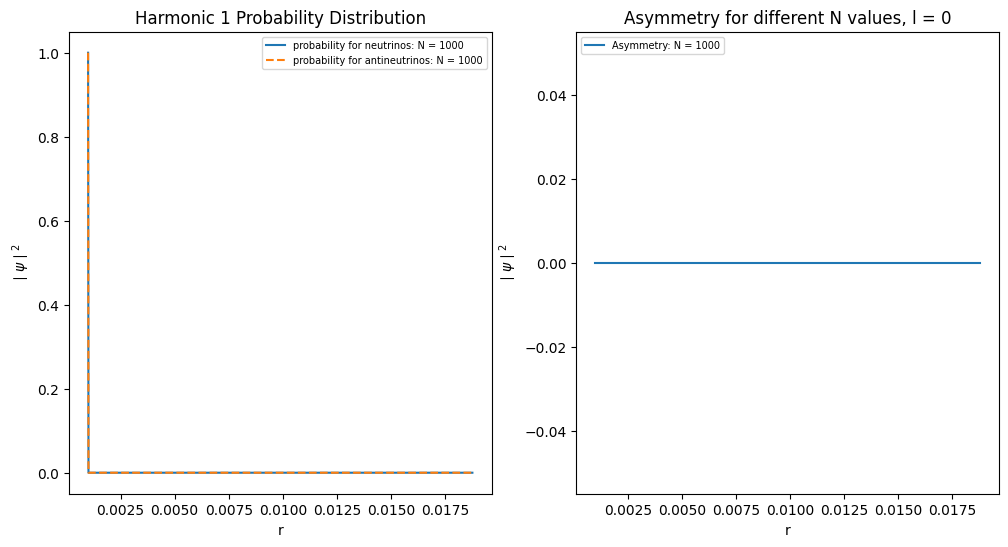

In [607]:
harmonic_many_N(1, [1000], 0)
# basically any time the asymmetry condition is not satisfied, there's no asymmetry, which is good
# if the condition is satisfied, there's sometimes asymmetry - inconclusive and runs into numerical issues sometimes
# with the asymmetry changing based on the number of points

k^2 condition cutoff:  2795.084971874737
50 950
[-6.23750625e+110 -2.49499373e+011 -2.49497448e+011 -2.49494341e+011
 -2.49490019e+011 -2.49484473e+011 -2.49477698e+011 -2.49469693e+011
 -2.49460458e+011 -2.49449993e+011 -2.49438297e+011 -2.49425371e+011
 -2.49411214e+011 -2.49395827e+011 -2.49379210e+011 -2.49361364e+011
 -2.49342287e+011 -2.49321980e+011 -2.49300445e+011 -2.49277679e+011
 -2.49253685e+011 -2.49228462e+011 -2.49202011e+011 -2.49174331e+011
 -2.49145423e+011 -2.49115288e+011 -2.49083925e+011 -2.49051335e+011
 -2.49017518e+011 -2.48982475e+011 -2.48946205e+011 -2.48908710e+011
 -2.48869989e+011 -2.48830044e+011 -2.48788873e+011 -2.48746479e+011
 -2.48702861e+011 -2.48658019e+011 -2.48611955e+011 -2.48564668e+011
 -2.48516159e+011 -2.48466428e+011 -2.48415476e+011 -2.48363304e+011
 -2.48309912e+011 -2.48255301e+011 -2.48199470e+011 -2.48142421e+011
 -2.48084154e+011 -2.48024670e+011 -2.47963969e+011 -2.47902053e+011
 -2.47838920e+011 -2.47774573e+011 -2.47709012e+011 -2.

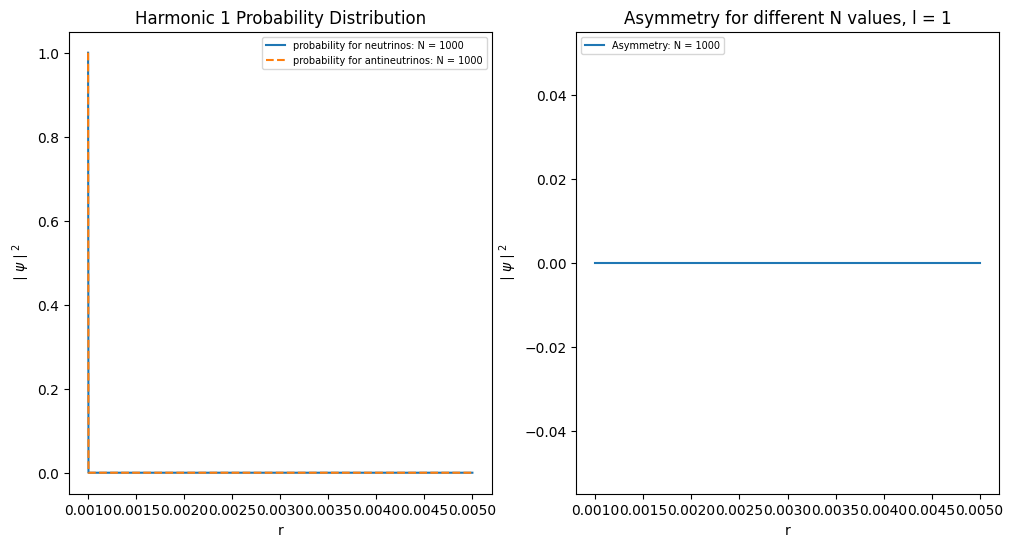

In [ ]:
harmonic_many_N(1, [1000], 1)

In [ ]:
#harmonic_many_N(1, [1500], 3000)
# for the real physical constants, everything gets pushed to the end around l = 1E7
# this would be when our simulation starts to break down
# this is independent of how wide we make the grid (holding the radius of the earth constant)

In [658]:
def harmonic_sum(N, l_max, increment, target_E):
    
    global r_values, psi_antinu, psi_nu
    
    r_values = np.linspace(0.00001, distance, N)
    lowest_eigenval = False
    kr = target_E * distance
    

    # Initialize sum arrays
    sum_psi_nu = np.zeros_like(r_values)
    sum_psi_antinu = np.zeros_like(r_values)

    for l in range(0, int(l_max), increment):  # loop over l values in a given increment
        print(f'{(l_max - l)/increment} l values remaining')
        E_pos, psi_nu = np.linalg.eigh(Hamiltonian_nu_25(N, r_values, l))
        E_neg, psi_antinu = np.linalg.eigh(Hamiltonian_antinu_25(N, r_values, l))
        
        # print(f'neutrino energy {n}:', E_pos[n-1])
        # print(f'antineutrino energy {n}:', E_neg[n-1])
        # if E_pos[n-1] < k_condition:
        #     print("Asymmetry condition satisfied for neutrinos")
        # else:
        #     print("Asymmetry condition not satisfied for neutrinos")
        # if E_neg[n-1] < k_condition:
        #     print("Asymmetry condition satisfied for antineutrinos")
        # else:
        #     print("Asymmetry condition not satisfied for antineutrinos")
        
        psi_nu = psi_nu.T
        psi_antinu = psi_antinu.T
        # sum_psi_nu += psi_nu[n-1]
        # sum_psi_antinu += psi_antinu[n-1]
        print(f'neutrino energy {l}:', E_pos)
        # Add this line to plot E_pos
        plt.plot(range(len(E_pos)-1), E_pos[1:], label = "E_pos")
        plt.plot(range(len(E_neg)-1), E_neg[1:], label = "E_neg")
        plt.xlabel('Index')
        plt.ylabel('E')
        plt.title('Eigenvalues with Index on X axis and Value on Y axis')
        plt.legend()
        plt.show()
        
        # Filter the eigenvalues, only adding the one for each l value closest to 1E-8
        min_diff_nu = np.inf
        min_diff_antinu = np.inf
        closest_psi_nu = None
        closest_psi_antinu = None
        
        

        for i, E in enumerate(E_pos):
            if .9*target_E < E < 1.1*target_E:
                diff = abs(E - target_E)
                if diff < min_diff_nu:
                    min_diff_nu = diff
                    closest_psi_nu = psi_nu[i]
                    closest_E_nu = E
                   

        for i, E in enumerate(E_neg):
            if .9*target_E < E < 1.1*target_E:
                diff = abs(E - target_E)
                if diff < min_diff_antinu:
                    min_diff_antinu = diff
                    closest_psi_antinu = psi_antinu[i]
                    closest_E_antinu = E
                    

        if closest_psi_nu is not None and closest_psi_antinu is not None:
            sum_psi_nu += closest_psi_nu
            print(f'neutrinos: l = {l}, E = {closest_E_nu}')
            sum_psi_antinu += closest_psi_antinu
            print(f'antineutrinos: l = {l}, E = {closest_E_antinu}')
        
        if E_pos[0] > 1.1 * target_E and E_neg[0] > 1.1 * target_E and lowest_eigenval == False:
            print(f"lowest nu eigenvalue is {E_pos[0]}\n lowest antinu eigenvalue is {E_neg[0]}")
            lowest_eigenval = True
            

        

    sum_psi_nu_normalized = normalize(sum_psi_nu)
    sum_psi_antinu_normalized = normalize(sum_psi_antinu)

    print(np.sum(np.abs(sum_psi_antinu_normalized)**2))
    print(np.sum(np.abs(sum_psi_nu_normalized)**2))
    

    return sum_psi_nu_normalized, sum_psi_antinu_normalized, N, l_max, increment, target_E



3.0 l values remaining
neutrino energy 0: [-2.44042979e+176 -9.76171816e-024 -9.76171521e-024 -9.76171030e-024
 -9.76170341e-024 -9.76169457e-024 -9.76168375e-024 -9.76167099e-024
 -9.76165623e-024 -9.76163954e-024 -9.76162094e-024 -9.76160025e-024
 -9.76157765e-024 -9.76155308e-024 -9.76152655e-024 -9.76149806e-024
 -9.76146760e-024 -9.76143517e-024 -9.76140078e-024 -9.76136442e-024
 -9.76132610e-024 -9.76128582e-024 -9.76124357e-024 -9.76119935e-024
 -9.76115317e-024 -9.76110502e-024 -9.76105491e-024 -9.76100284e-024
 -9.76094880e-024 -9.76089279e-024 -9.76083482e-024 -9.76077488e-024
 -9.76071298e-024 -9.76064912e-024 -9.76058329e-024 -9.76051550e-024
 -9.76044574e-024 -9.76037401e-024 -9.76030032e-024 -9.76022467e-024
 -9.76014705e-024 -9.76006747e-024 -9.75998592e-024 -9.75990241e-024
 -9.75981694e-024 -9.75972950e-024 -9.75964009e-024 -9.75954872e-024
 -9.75945539e-024 -9.75936009e-024 -9.75926283e-024 -9.75916360e-024
 -9.75906241e-024 -9.75895926e-024 -9.75885414e-024 -9.758747

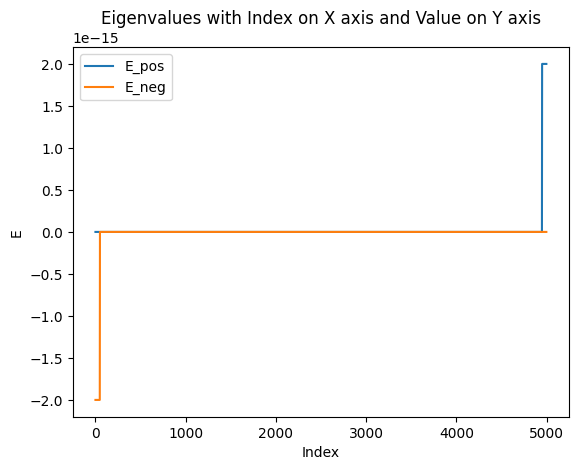

2.0 l values remaining
neutrino energy 100000: [-2.44042979e+176  9.68083406e-022  9.69301757e-022  9.70280817e-022
  9.71131049e-022  9.71894792e-022  9.72593809e-022  9.73241010e-022
  9.73844700e-022  9.74410465e-022  9.74942140e-022  9.75442429e-022
  9.75913515e-022  9.76358025e-022  9.76780367e-022  9.77187275e-022
  9.77585996e-022  9.77981617e-022  9.78376489e-022  9.78771374e-022
  9.79166455e-022  9.79561767e-022  9.79957317e-022  9.80353105e-022
  9.80749132e-022  9.81145398e-022  9.81541903e-022  9.81938647e-022
  9.82335630e-022  9.82732853e-022  9.83130316e-022  9.83528018e-022
  9.83925962e-022  9.84324145e-022  9.84722569e-022  9.85121233e-022
  9.85520139e-022  9.85919286e-022  9.86318674e-022  9.86718304e-022
  9.87118175e-022  9.87518288e-022  9.87918644e-022  9.88319242e-022
  9.88720082e-022  9.89121165e-022  9.89522491e-022  9.89924060e-022
  9.90325872e-022  9.90727928e-022  9.91130228e-022  9.91532771e-022
  9.91935559e-022  9.92338591e-022  9.92741867e-022  9.9

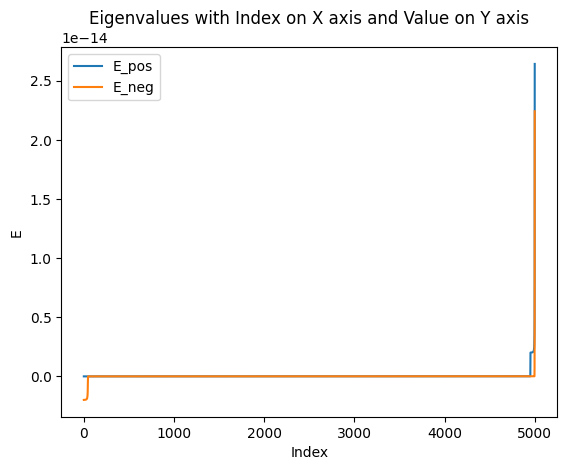

1.0 l values remaining
neutrino energy 200000: [-2.44042979e+176  3.89906530e-021  3.90194661e-021  3.90415180e-021
  3.90598868e-021  3.90763432e-021  3.90921525e-021  3.91078468e-021
  3.91235371e-021  3.91392359e-021  3.91549441e-021  3.91706617e-021
  3.91863888e-021  3.92021254e-021  3.92178714e-021  3.92336269e-021
  3.92493919e-021  3.92651663e-021  3.92809503e-021  3.92967438e-021
  3.93125468e-021  3.93283593e-021  3.93441813e-021  3.93600129e-021
  3.93758541e-021  3.93917047e-021  3.94075650e-021  3.94234348e-021
  3.94393142e-021  3.94552032e-021  3.94711017e-021  3.94870099e-021
  3.95029277e-021  3.95188551e-021  3.95347921e-021  3.95507387e-021
  3.95666950e-021  3.95826609e-021  3.95986365e-021  3.96146218e-021
  3.96306167e-021  3.96466213e-021  3.96626355e-021  3.96786595e-021
  3.96946932e-021  3.97107366e-021  3.97267897e-021  3.97428525e-021
  3.97589250e-021  3.97750073e-021  3.97910993e-021  3.98072011e-021
  3.98233127e-021  3.98394340e-021  3.98555651e-021  3.9

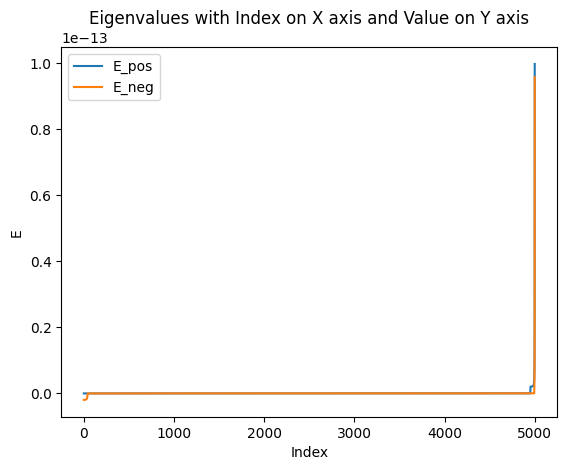

nan
nan


C:\Users\natha\AppData\Local\Temp\ipykernel_23612\1700456597.py:56: RuntimeWarning: invalid value encountered in divide
  psi_norm = psi / norm  # Normalize the vector


In [661]:
psi_nu_normalized, psi_antinu_normalized, N, l_max, increment, target_E = harmonic_sum(5000, 300000, 100000, 1E-8)

In [494]:
def harmonic_sum_graphing(sum_psi_nu_normalized, sum_psi_antinu_normalized, r_values, N, l_max, increment, target_E):
    
    asym_normalized = []
    asym_over_delta = []
    
    # Create three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 6))

    # Plot the sum of the normalized wavefunctions
    ax1.plot(r_values, np.abs(sum_psi_nu_normalized / r_values)**2, color = 'blue', label='Sum for neutrinos')
    ax1.plot(r_values, np.abs(sum_psi_antinu_normalized / r_values)**2, color = 'green', label='Sum for antineutrinos')

    # Plot the asymmetry
    for j in range(0, len(r_values)):
        asym_over_delta.append((np.abs(sum_psi_nu_normalized[j] / r_values[j])**2 - np.abs(sum_psi_antinu_normalized[j] / r_values[j])**2)/(m * U / target_E))
        if np.abs(sum_psi_nu_normalized[j] / r_values[j])**2 == np.abs(sum_psi_antinu_normalized[j] / r_values[j])**2 and np.abs(sum_psi_nu_normalized[j] / r_values[j])**2 == 0:
            asym_normalized.append(0)
        else:
            asym_normalized.append((np.abs(sum_psi_nu_normalized[j] / r_values[j])**2 - np.abs(sum_psi_antinu_normalized[j] / r_values[j])**2)/(np.abs(sum_psi_nu_normalized[j] / r_values[j])**2 + np.abs(sum_psi_antinu_normalized[j] / r_values[j])**2))
    ax2.plot(r_values, asym_normalized, label=f'Asymmetry: N = {N}') # graphing numerically
    ax3.plot(r_values, asym_over_delta, label=f'Asymmetry over delta: N = {N}') # graphing numerically

    # Set labels and title for the first subplot
    ax1.set_xlabel('r (1/ev)')
    ax1.set_ylabel(r'$\mid\psi\mid^2$', fontsize=15)
    ax1.set_yscale('linear')
    ax1.set_xscale('linear')
    ax1.set_title(f'Sum of k^2 ~ {target_E} for \nfirst {l_max} l values, increment of {increment}')
    ax1.axvline(x=R, color='red', linestyle='--', linewidth=1)  # Add vertical line at x = R

    # Set labels and title for the second subplot
    ax2.set_xlabel('r (1/ev)')
    ax2.set_ylabel(r'$\frac{\psi_\nu^2 - \psi_{\overline{\nu}}^2}{\psi_\nu^2 + \psi_{\overline{\nu}}^2}$', fontsize=15)
    ax2.set_yscale('linear')
    ax2.set_xscale('linear')    
    ax2.set_title(f'Asymmetry for Sum of k^2 ~ {target_E} \nfor first {l_max} l values')
    ax2.axvline(x=R, color='red', linestyle='--', linewidth=1)  # Add vertical line at x = R
    print(asym_normalized)

    ax3.set_xlabel('r (1/ev)')
    ax3.set_ylabel(r'$\frac{\psi_\nu^2 - \psi_{\overline{\nu}}^2}{\delta}$', fontsize=15)
    ax3.set_yscale('linear')
    ax3.set_xscale('linear')
    ax3.set_title(f'Asymmetry over delta for Sum of k^2 ~ {target_E} \nfor first {l_max} l values')
    ax3.axvline(x=R, color='red', linestyle='--', linewidth=1)  # Add vertical line at x = R



    # Display legend
    ax1.legend()
    ax2.legend()
    ax3.legend()

    plt.savefig('1D_plots/sum_function.png')
    plt.show()

    fig, (ax5, ax4) = plt.subplots(1, 2, figsize=(18, 6))
    

    ax5.plot(r_values, asym_normalized, label=f'Asymmetry: N = {N}') # graphing numerically
    ax5.set_xlabel('r (1/ev)')
    ax5.set_ylabel(r'$\frac{\psi_\nu^2 - \psi_{\overline{\nu}}^2}{\psi_\nu^2 + \psi_{\overline{\nu}}^2}$', fontsize=15)
    ax5.set_yscale('linear')
    ax5.set_xscale('linear')    
    ax5.set_title(f'Zoomed Asymmetry around R = {R}')
    ax5.axvline(x=R, color='red', linestyle='--', linewidth=1)  # Add vertical line at x = R
    ax5.set_xlim(.8 * R, 1.2 * R)

    ax4.plot(r_values, asym_over_delta, label=f'Asymmetry over delta: N = {N}')
    ax4.set_xlabel('r (1/ev)')
    ax4.set_ylabel(r'$\frac{\psi_\nu^2 - \psi_{\overline{\nu}}^2}{\delta}$', fontsize=14)  # Increase font size
    ax4.set_yscale('linear')
    ax4.set_xscale('linear')
    ax4.set_title(f'Zoomed Asymmetry over delta around R = {R}')
    ax4.set_ylim(-2E-10, 2E-10)

    # Set x-limits to zoom in around R
    ax4.set_xlim(.8 * R, 1.2 * R)
    ax4.axvline(x=R, color='red', linestyle='--', linewidth=1)  # Add vertical line at x = R
    


    # Display legend
    ax4.legend()
    ax5.legend()

    plt.savefig('1D_plots/zoomed_asymmetry_over_delta.png')
    plt.show()
    

[0, -0.9995640654361738, -0.9995597993480086, -0.9995412732446255, -0.9994916346706334, -0.9993695809157853, -0.9990243422713619, -0.9973481727596676, 0.9972693146758382, 0.999548348790645, 0.9998648909049531, 0.6584069091507944, -0.999999190910665, -0.9999999969460234, -0.9999999717922311, -0.9914280087487988, 0.9987204619050529, 0.9999999718262128, 0.9991270729929699, -0.9790469838876147, -0.9999997603184257, -0.999999999863361, -0.9774577716179749, 0.9996897553623079, 0.9999976261704996, 0.9999473373646375, 0.417935840873262, -0.9996089427340255, -0.9998926686212376, -0.9997342749374406, 0.8202327031433688, 0.9992310354063686, 0.9958682426053677, 0.9624511728126478, -0.9182587059729446, -0.9539100843551869, -0.954161767044934, -0.999996894905401, 0.7799779725772785, 0.6120342011255471, 0.3297352106548825, -0.03823183861519587, 0.3287126201345447, 0.6109846335978557, 0.8097434711253078, -0.9277973118013931, -0.9995945143046897, -0.9991459978472679, -0.9962349720688425, 0.324742657185

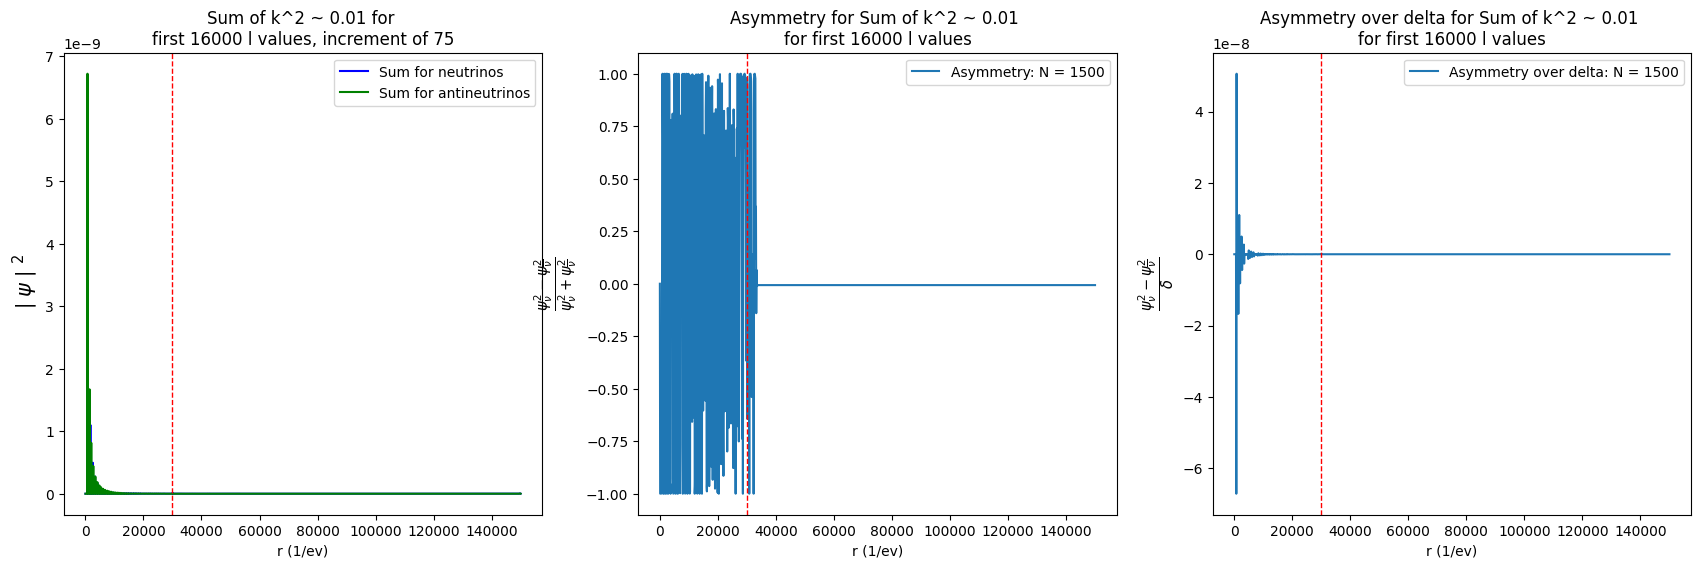

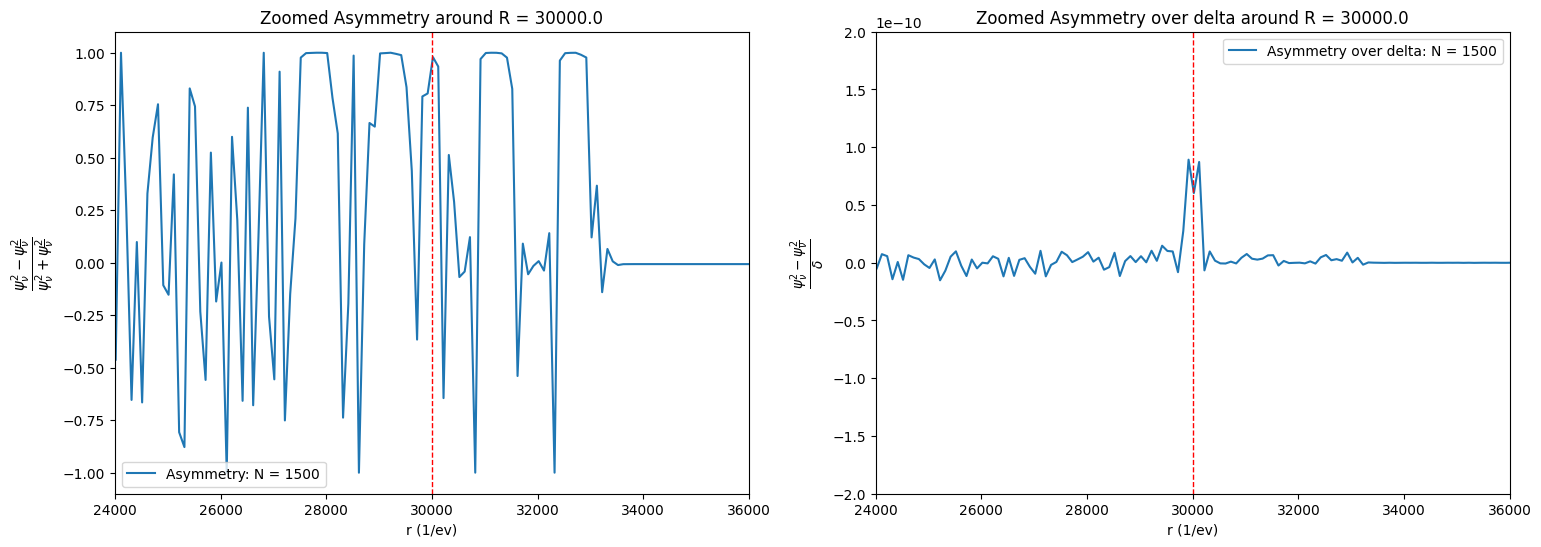

In [501]:
harmonic_sum_graphing(psi_nu_normalized, psi_antinu_normalized, r_values, N, l_max, increment, target_E)

In [ ]:
def harmonic_sum_cutoff(N, l_max, increment, cutoff):
    
    global r_values, psi_antinu, psi_nu
    
    r_values = np.linspace(0.001, distance, N)
    lowest_eigenval = False
    kr = cutoff * distance
    

    # Initialize sum arrays
    sum_psi_nu = np.zeros_like(r_values)
    sum_psi_antinu = np.zeros_like(r_values)

    for l in range(0, int(l_max), increment):  # loop over l values in a given increment
        print(f'{(l_max - l)/increment} l values remaining')
        E_pos, psi_nu = np.linalg.eigh(Hamiltonian_nu_25(N, r_values, l))
        E_neg, psi_antinu = np.linalg.eigh(Hamiltonian_antinu_25(N, r_values, l))
        
        # print(f'neutrino energy {n}:', E_pos[n-1])
        # print(f'antineutrino energy {n}:', E_neg[n-1])
        # if E_pos[n-1] < k_condition:
        #     print("Asymmetry condition satisfied for neutrinos")
        # else:
        #     print("Asymmetry condition not satisfied for neutrinos")
        # if E_neg[n-1] < k_condition:
        #     print("Asymmetry condition satisfied for antineutrinos")
        # else:
        #     print("Asymmetry condition not satisfied for antineutrinos")
        
        psi_nu = psi_nu.T
        psi_antinu = psi_antinu.T
        # sum_psi_nu += psi_nu[n-1]
        # sum_psi_antinu += psi_antinu[n-1]

        
        # Filter the eigenvalues, only adding the ones where E < cutoff
        
        E_nu_quantity = 0
        E_antinu_quantity = 0

        for i, E in enumerate(E_pos):
            if E <= cutoff:
                sum_psi_nu += psi_nu[i]
                E_nu_quantity += 1
        print(f'neutrinos: l = {l}, number added for neutrinos: {E_nu_quantity}')

        for i, E in enumerate(E_neg):
            if E <= cutoff:
                sum_psi_antinu += psi_antinu[i]
                E_antinu_quantity += 1
        print(f'antineutrinos: l = {l}, number added for antineutrinos: {E_antinu_quantity}')
            

        

    sum_psi_nu_normalized = normalize(sum_psi_nu)
    sum_psi_antinu_normalized = normalize(sum_psi_antinu)

    print(np.sum(np.abs(sum_psi_antinu_normalized)**2))
    print(np.sum(np.abs(sum_psi_nu_normalized)**2))
    

    return sum_psi_nu_normalized, sum_psi_antinu_normalized, N, l_max, increment, cutoff



In [ ]:
psi_nu_cutoff, psi_antinu_cutoff, N, l_max, increment, cutoff = harmonic_sum_cutoff(1200, 500000, 700, 10)

714.2857142857143 l values remaining
neutrinos: l = 0, number added for neutrinos: 1200
antineutrinos: l = 0, number added for antineutrinos: 1200
713.2857142857143 l values remaining
neutrinos: l = 700, number added for neutrinos: 1198
antineutrinos: l = 700, number added for antineutrinos: 1198
712.2857142857143 l values remaining
neutrinos: l = 1400, number added for neutrinos: 1196
antineutrinos: l = 1400, number added for antineutrinos: 1196
711.2857142857143 l values remaining
neutrinos: l = 2100, number added for neutrinos: 1194
antineutrinos: l = 2100, number added for antineutrinos: 1194
710.2857142857143 l values remaining
neutrinos: l = 2800, number added for neutrinos: 1192
antineutrinos: l = 2800, number added for antineutrinos: 1192
709.2857142857143 l values remaining
neutrinos: l = 3500, number added for neutrinos: 1191
antineutrinos: l = 3500, number added for antineutrinos: 1191
708.2857142857143 l values remaining
neutrinos: l = 4200, number added for neutrinos: 1189

[-0.0001272288608155617, -0.0001267682274477052, -0.0001301471481928416, -0.00012695488336779743, -0.0001253225275374995, -0.0001270597858148459, -0.00012090162021777369, -0.00012387979769180603, -0.00013996964735228014, -0.00012865076677308308, -0.00012334414593939447, -0.00012713640255423875, -0.00012517573076979615, -0.00012738655398438487, -0.00011893483176090208, -0.00012059109169465691, -0.00014162786105034763, -0.00013120090704814204, -0.0001307765200821503, -0.0001271119712358348, -0.0001249934426325575, -0.00012843614945938573, -0.00010715117001914342, -0.0836633407593379, -0.00016338245399692995, -0.00013609150031772268, -0.0001249613975516804, -0.00012378530602473548, -0.00013267279370198347, -0.00011228223587343624, -0.00019067503377303272, -0.00021297873882526963, -5.0948120358905115e-05, -6.647380095804628e-05, -0.0001385438354972715, -0.00011946058816128627, -0.00013075085030231606, 0.0980891610867999, 0.10395892331045556, -0.005549765815067509, -0.00027479080522395584, 

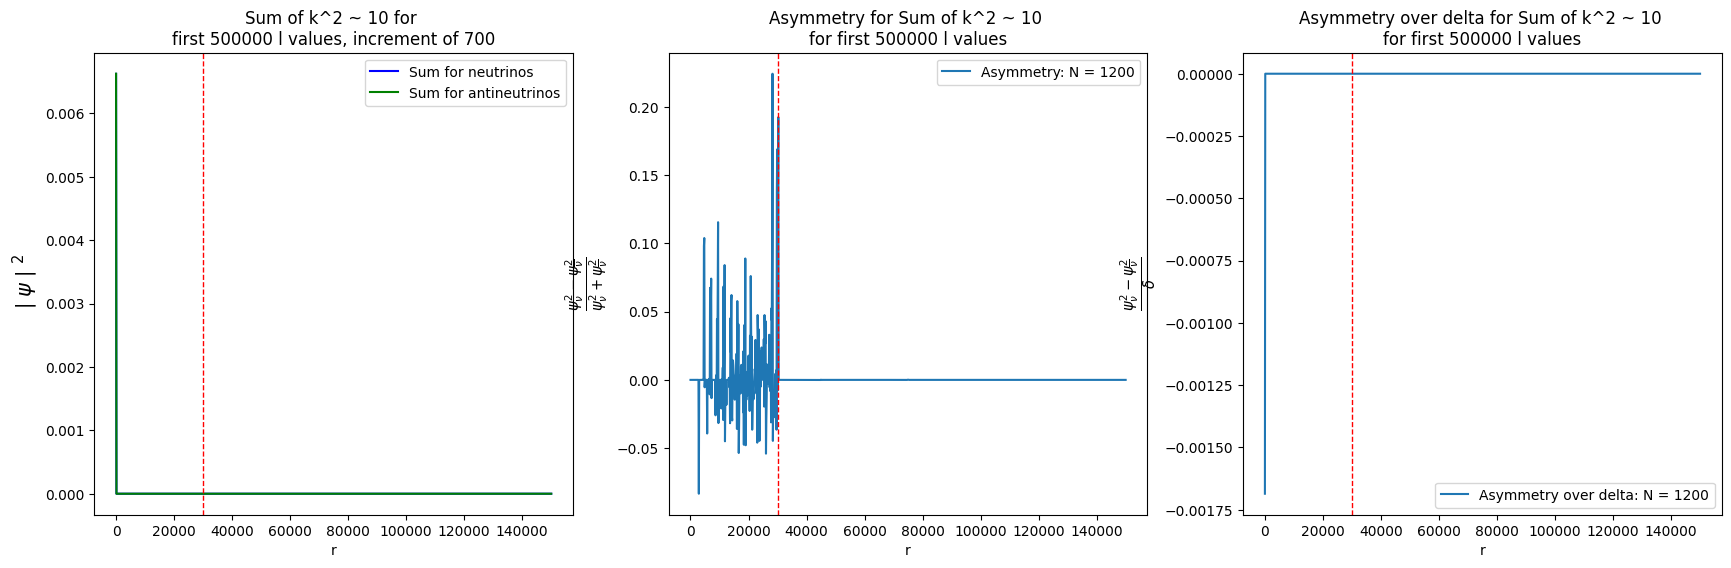

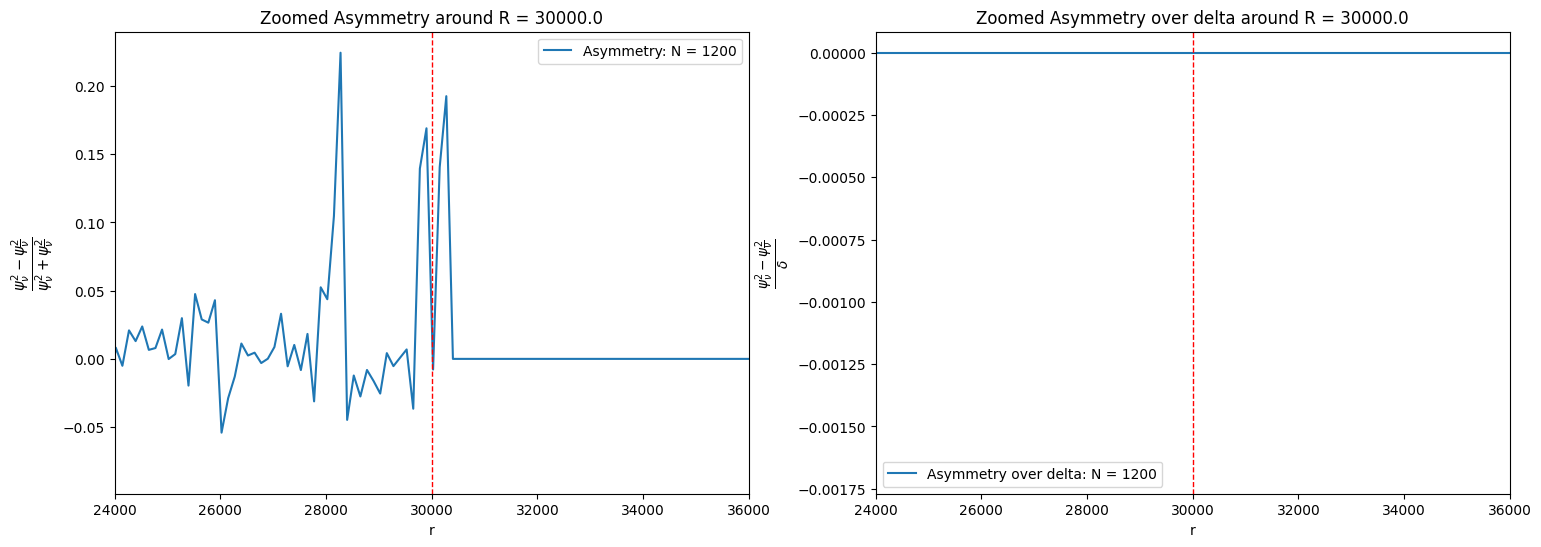

In [ ]:
harmonic_sum_graphing(psi_nu_cutoff, psi_antinu_cutoff, r_values, N, l_max, increment, cutoff)

In [ ]:
# define the potentials, treating it for now as a 1D step function


def potential_nu(N, r, l):

    H = np.zeros((N,N))
    for i in range(0, H.shape[0]):
        #try just a step function
        
        # inside the earth:
        # it's plus delta because -mU = + delta/k^2
        V_eff_in = kprime_nu**2 + 2 * delta * kprime_nu**2 - (l * (l + 1))/(r[i]**2)

        # outside the earth:
        V_eff_out = k**2 * (1  - (l * (l + 1))/(k**2 * r[i]**2))


        # if i < 3:
        #     H[i,i] = 1E20        
        # el
        if i < int(earth_cutoff * N):
            H[i,i] = V_eff_in
            #print("V_eff_in: ", V_eff_in)
        else:
            H[i,i] = V_eff_out
            #print("V_eff_out: ", V_eff_out)
    #print("nu: \n",H)

    return H



def potential_antinu(N, r, l):

    H = np.zeros((N,N))
    for i in range(0, H.shape[0]):
        #try just a step function
        global V_eff_in_neg, V_eff_out_neg
        # inside the earth:
        V_eff_in_neg = kprime_antinu**2 - 2 * delta  * kprime_antinu**2 - (l * (l + 1))/(r[i]**2)

        # outside the earth:
        V_eff_out_neg = k**2 * (1  - (l * (l + 1))/(k**2 * r[i]**2))

        # if i < 3:
        #     H[i,i] = 1E20
        # el
        if i < int(earth_cutoff * N):
            H[i,i] = V_eff_in_neg
            #print("V_eff_in_neg: ", V_eff_in_neg)
        else:
            H[i,i] = V_eff_out_neg
            #print("V_eff_out_neg: ", V_eff_out_neg)
    #print("antinu: \n",H)
    return H

potential_nu(1000, np.linspace(.01, distance, 1000), 10)
potential_antinu(1000, np.linspace(.01, distance, 1000), 1E10)

NameError: name 'kprime_nu' is not defined

In [ ]:
# create the equation to be solved
def Hamiltonian_nu(N, r, l):
    H = second_deriv(N, distance) +  (2/r) * first_deriv(N, distance) + potential_nu(N,r, l)
    return H

def Hamiltonian_antinu(N, r, l):
    H = second_deriv(N, distance) + (2/r) *  first_deriv(N, distance) + potential_antinu(N,r, l)
    return H


-1099999.99999999
-1099999.99999999
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.

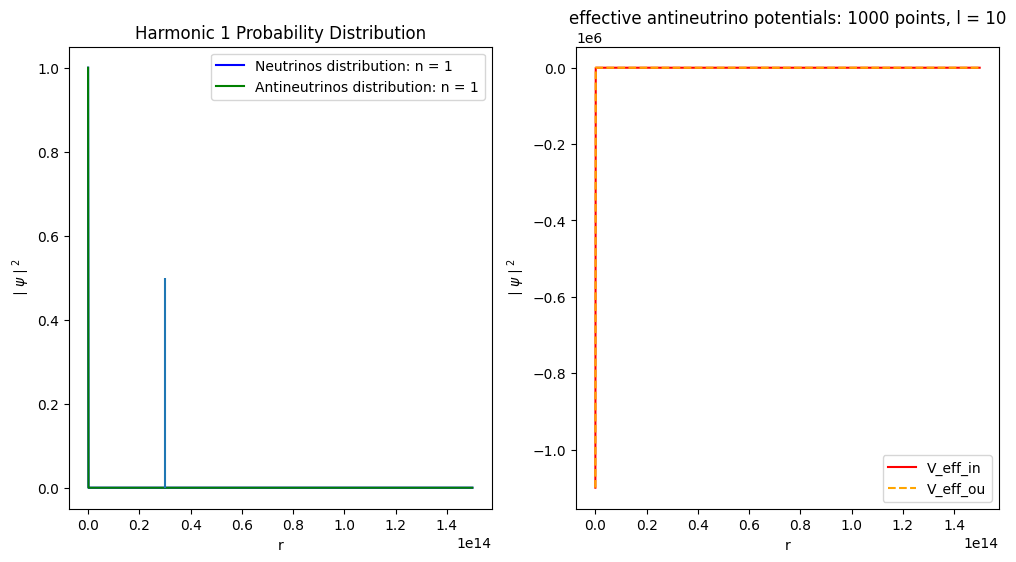

In [ ]:
# function to graph the nth harmonic
#try solving equation 25 instead
# IGNORE THIS CHUNK FOR NOW - THIS IS THE EQUATION 11 STUFF WHICH ISN'T WORKING PROPERLY. THE EQUATION 25 STUFF BELOW IS (KINDA) WORKING

# fix my 2mU to delta definition - it's wrong (tried fixing it make sure its right)

def harmonic(n, N, l):
    
    global r_values, psi_antinu, psi_nu
    
    r_values = np.linspace(.01, distance, N)
    #might try using eig instead of eigh because the matrices are no longer symmetric
    E_pos, psi_nu = np.linalg.eig(potential_nu(N, r_values, l))
    E_neg, psi_antinu = np.linalg.eig(potential_antinu(N, r_values, l))
    print(E_pos[0])
    print(E_neg[0])

    psi_nu = psi_nu.T
    psi_antinu = psi_antinu.T
    print(psi_nu[0])

    # Create two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the first two graphs on the first subplot
    ax1.plot(r_values, np.abs(psi_nu[n-1])**2, color = 'blue', label=f'Neutrinos distribution: n = {n}') # graphing numerically
    ax1.plot(r_values, np.abs(psi_antinu[n-1])**2, color = 'green', label=f'Antineutrinos distribution: n = {n}') # graphing numerically

    asymmetry = (np.abs(psi_nu[n-1])**2 - np.abs(psi_antinu[n-1])**2)# / (np.abs(psi_nu[n-1])**2 + np.abs(psi_antinu[n-1])**2)
    print("Asymmetry;", asymmetry)
    

    # Plot the asymmetry on the second subplot
    ax2.plot(r_values, kprime_antinu**2 * (1 - 2 * delta - (l * (l + 1))/(kprime_antinu**2 * r_values**2)), color='red', label='V_eff_in') # graphing numerically
    ax2.plot(r_values, k**2 * (1  - (l * (l + 1))/(k**2 * r_values**2)), color='orange', label='V_eff_ou', linestyle = '--') # graphing numerically
    
    # graph the potential on the same plot
    ax1.vlines(3E13, ymin = 0, ymax=.5)
    #ax2.vlines(3E13, ymin = 0, ymax=1)

    # Set labels and title for the first subplot
    ax1.set_xlabel('r')
    ax1.set_ylabel(r'$\mid\psi\mid^2$')
    ax1.set_yscale('linear')
    ax1.set_xscale('linear')
    ax1.set_title(f'Harmonic {n} Probability Distribution')

    # Set labels and title for the second subplot
    ax2.set_xlabel('r')
    ax2.set_ylabel(r'$\mid\psi\mid^2$')
    ax2.set_yscale('linear')
    ax2.set_xscale('linear')
    ax2.set_title(f'effective antineutrino potentials: {N} points, l = {l}')

    # Display legend
    ax1.legend()
    ax2.legend()

    # Save the figure
    plt.savefig('1D_plots/step_function.png')

    # Show the plot
    plt.show()



# harmonic(1, 4000, l=1E8)
harmonic(1, 1000, l=10)
# harmonic(1, 4000, l=1E12)
# harmonic(1, 5000, l=1E8)
# harmonic(1, 5000, l=1E10)
# harmonic(1, 5000, l=1E12)
# harmonic(1, 6000, l=1E8)
# harmonic(1, 6000, l=1E10)
# harmonic(1, 6000, l=1E12)